# Logistic Regression Modeling

## Import

In [270]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator

## Preprocessing Methods
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [272]:
import sys
import os
import pprint
sys.path.insert(
    0,
    os.path.abspath("..")
)

In [273]:
from Experiments.preprocessing import Preprocesser
from Experiments.all_minilm import HuggingFaceClassifier
from Experiments.svd import TextClassifier
from Experiments.classifier import Classifier

# Choose Preprocessing Methods

What's Important?
- Stopword Removal (max_df and min_df for tfidf-vectorizer)
- What dates of data should I include? Try seeing topic trends.
- Feature Importance
- Evaluation Metrics

Our Pipeline should look like this:
**Preprocessing:**
- Combine relevant columns into one column
- Apply stopword removal

**Vectorizer:**
- Configure vectorizer parameters and pickle if necessary (On Colab GPU or locally)

**Evaluate Feature Importance:**

**Cross-Validate and Get Test Results**





# EDA on Topic Trends (If Time)

Use BERTopic

# Experiments on CDESCR

## Experiment 1: 
TFIDF Vectorizer, with standard stopwords removal and lemmatization, into LogisticRegression

In [274]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords",
    custom_vectorizer_name="tfidf_binary_unigram_bigram",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,2),
        min_df=20,
        max_df=0.7,
        binary=True
    )
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:72: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [275]:
c = Classifier(
    classifier=LogisticRegression,
    custom_classifier_name="base_lr",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"]
)

In [276]:
c.fit()

In [277]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.99      1.00      1150\n'
 '           1       1.00      1.00      1.00      2587\n'
 '\n'
 '    accuracy                           1.00      3737\n'
 '   macro avg       1.00      1.00      1.00      3737\n'
 'weighted avg       1.00      1.00      1.00      3737\n')


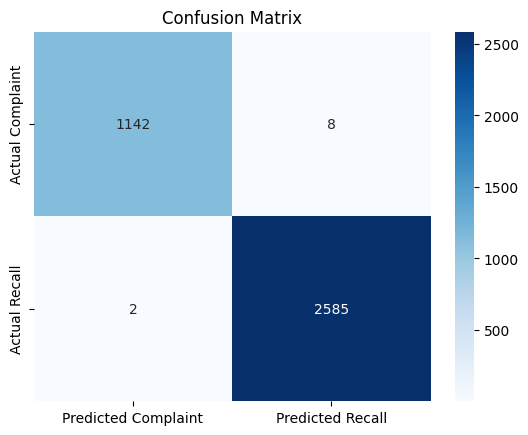

In [278]:
_ = c.plot_heatmap()

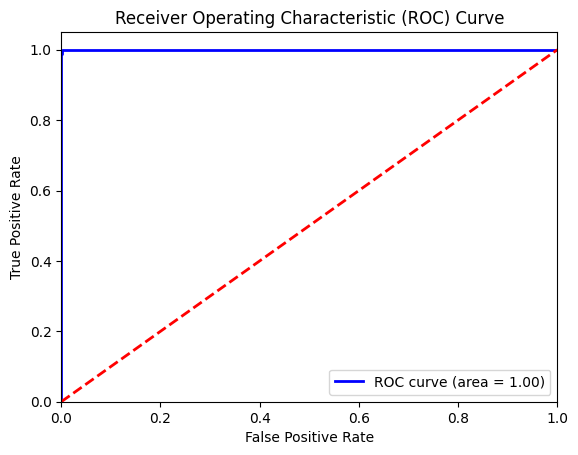

In [279]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


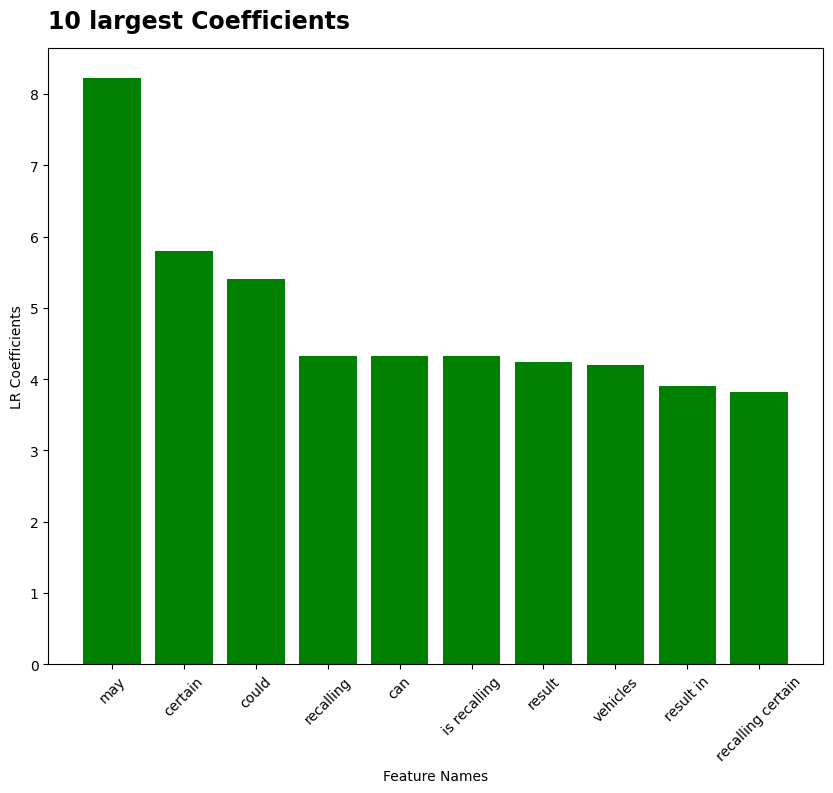

In [280]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=10
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


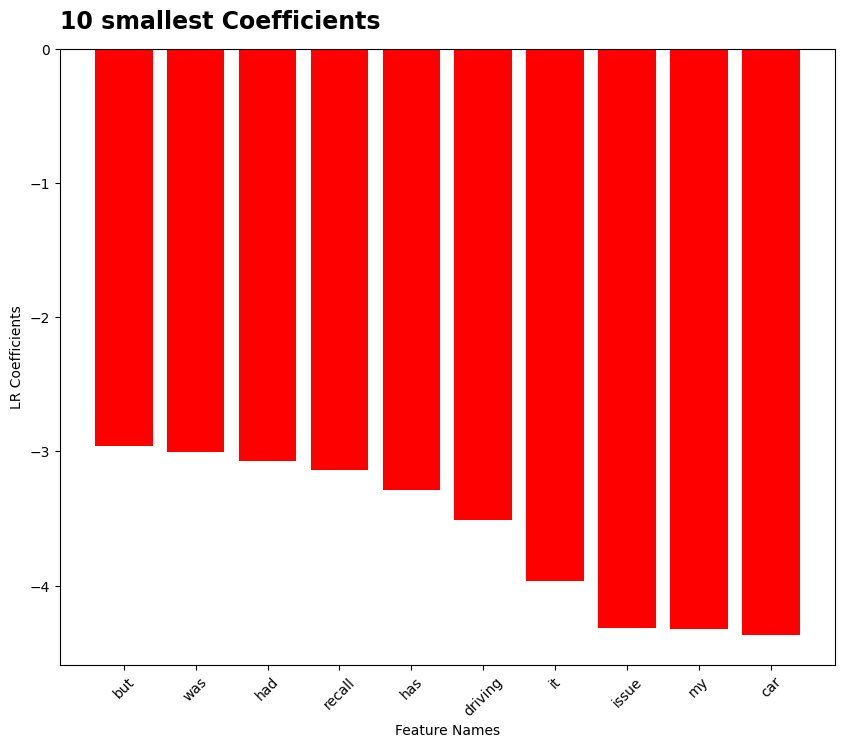

In [281]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=10
)

In [282]:
top_50_feature_importance_1 = c.get_feature_importance(
    p.vectorizer,
    type="largest",
    top=50
)

In [283]:
bottom_50_feature_importance_1 = c.get_feature_importance(
    p.vectorizer,
    type="smallest",
    top=50
)

## Experiment 2: 
TFIDF Vectorizer, with specific stopwords removal and lemmatization, into LogisticRegression

In [357]:
stopwords_top = top_50_feature_importance_1["feature_names"].tolist()
stopwords_bottom = bottom_50_feature_importance_1["feature_names"].tolist()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [358]:
stopwords_top = [stopword for stopword in stopwords_top if stopword.find(" ") == -1]
stopwords_bottom = [stopword for stopword in stopwords_bottom if stopword.find(" ") == -1]

In [359]:
stopwords_top = list(set(stopwords_top) - {"motor"})
stopwords_bottom = list(set(stopwords_bottom) - {"coolant", "motor", "transmission"})

In [381]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords_2",
    extra_stopwords = (
        stopwords_top + stopwords_bottom
    ),
    custom_vectorizer_name="tfidf_binary_unigram_bigram_2",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,1),
        min_df=20,
        max_df=0.7,
        binary=True
    ),
    is_stem=False
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:74: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [ ]:
c = Classifier(
    classifier=LogisticRegression,
    custom_classifier_name="lr_stopwords_2",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"]
)

In [383]:
c.fit()

In [384]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.97      0.99      1150\n'
 '           1       0.99      1.00      0.99      2587\n'
 '\n'
 '    accuracy                           0.99      3737\n'
 '   macro avg       0.99      0.99      0.99      3737\n'
 'weighted avg       0.99      0.99      0.99      3737\n')


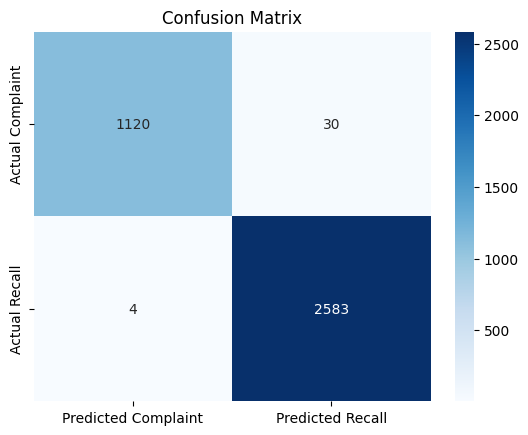

In [385]:
_ = c.plot_heatmap()

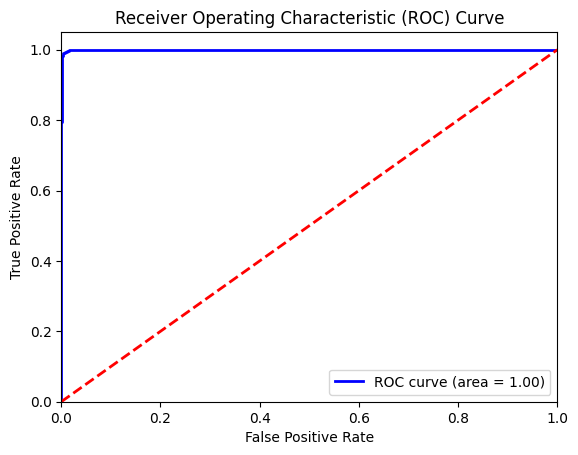

In [386]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


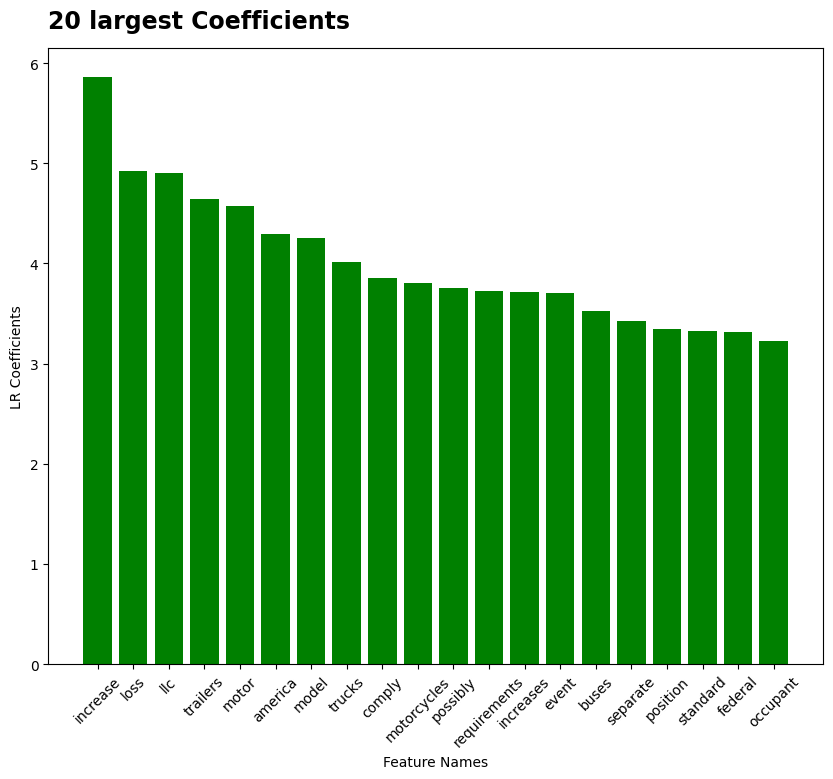

In [387]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=20
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


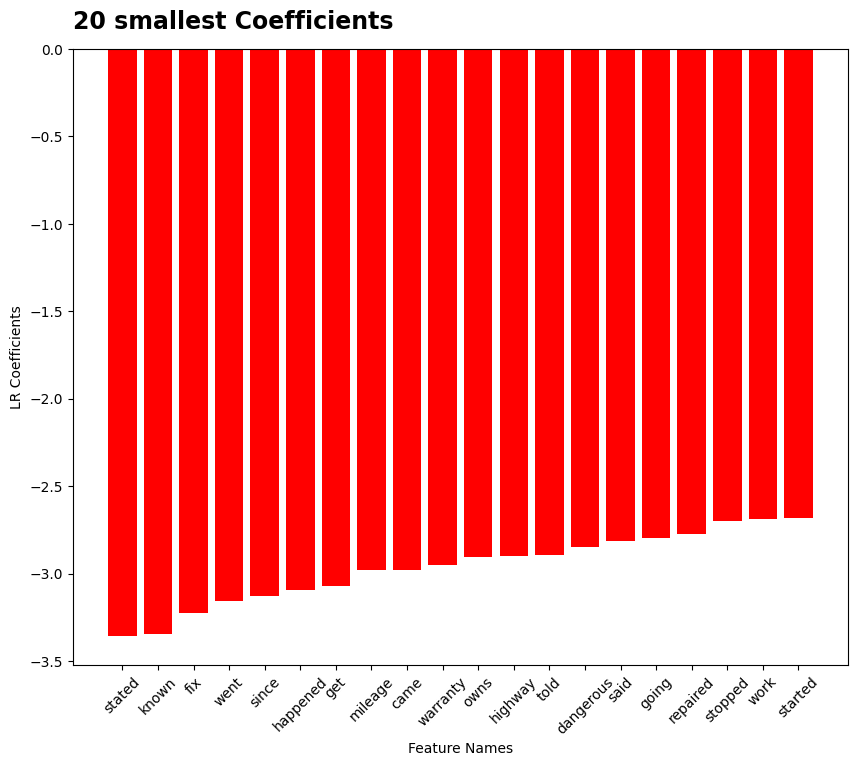

In [388]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=20
)

In [389]:
top_50_stopwords_2 = c.get_top_stopwords(
    p.vectorizer,
    type="largest"
)
bottom_50_stopwords_2 = c.get_top_stopwords(
    p.vectorizer,
    type="smallest"
)

## Experiment 3: 
Try lower max_df

In [392]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords",
    custom_vectorizer_name="tfidf_binary_unigram_bigram_max_df_0.3",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,1),
        min_df=20,
        max_df=0.3,
        binary=True
    ),
    is_stem=False
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:74: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [ ]:
c = Classifier(
    classifier=LogisticRegression,
    custom_classifier_name="lr_stopwords_max_df_0.3",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"]
)

In [394]:
c.fit()

In [395]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.99      0.99      1150\n'
 '           1       0.99      1.00      1.00      2587\n'
 '\n'
 '    accuracy                           1.00      3737\n'
 '   macro avg       1.00      0.99      0.99      3737\n'
 'weighted avg       1.00      1.00      1.00      3737\n')


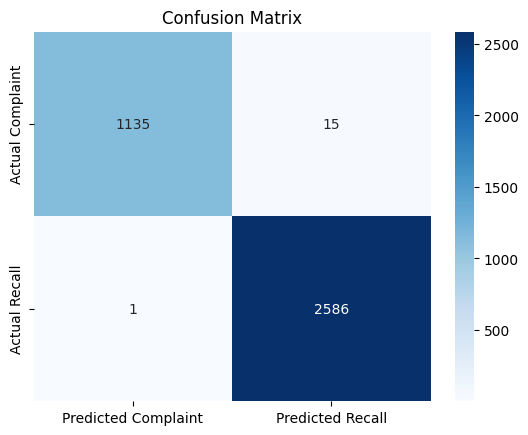

In [396]:
_ = c.plot_heatmap()

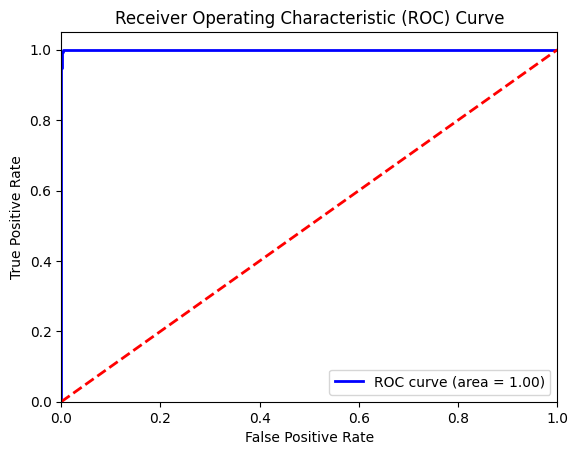

In [398]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


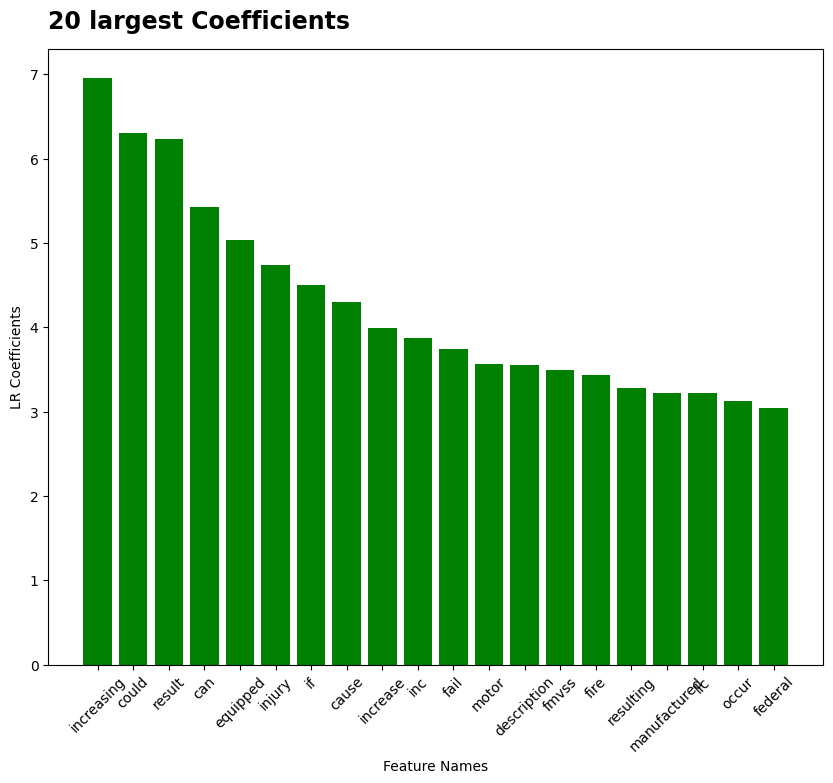

In [399]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=20
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


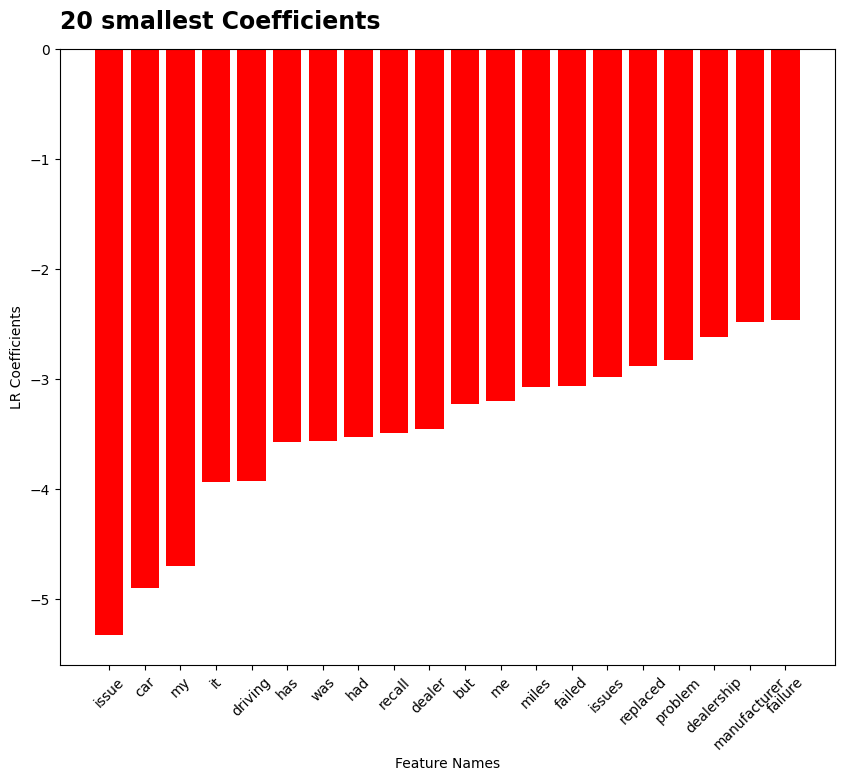

In [400]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=20
)

## Experiment 4: 
Try even lower max_df

In [424]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords",
    custom_vectorizer_name="tfidf_binary_unigram_bigram_max_df_0.01",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,1),
        min_df=20,
        max_df=0.01,
        binary=True
    ),
    is_stem=False
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:74: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [425]:
c = Classifier(
    classifier=LogisticRegression,
    custom_classifier_name="lr_stopwords_max_df_0.01",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"]
)

In [426]:
c.fit()

In [427]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.98      0.90      0.94      1150\n'
 '           1       0.96      0.99      0.97      2587\n'
 '\n'
 '    accuracy                           0.96      3737\n'
 '   macro avg       0.97      0.95      0.96      3737\n'
 'weighted avg       0.97      0.96      0.96      3737\n')


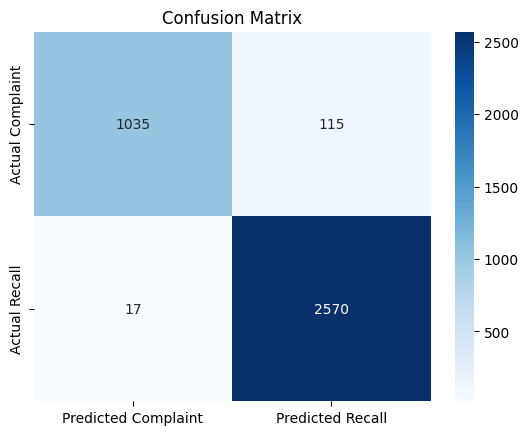

In [428]:
_ = c.plot_heatmap()

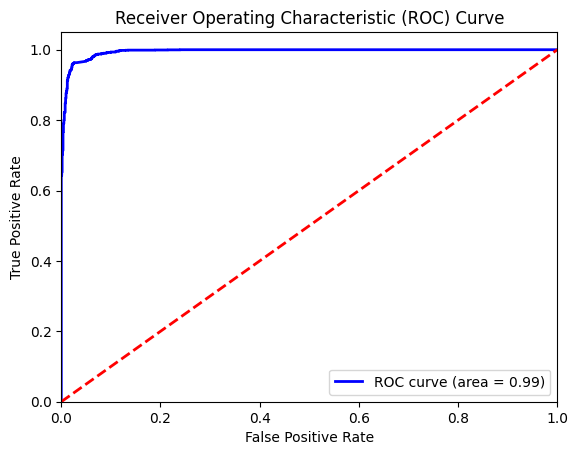

In [429]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


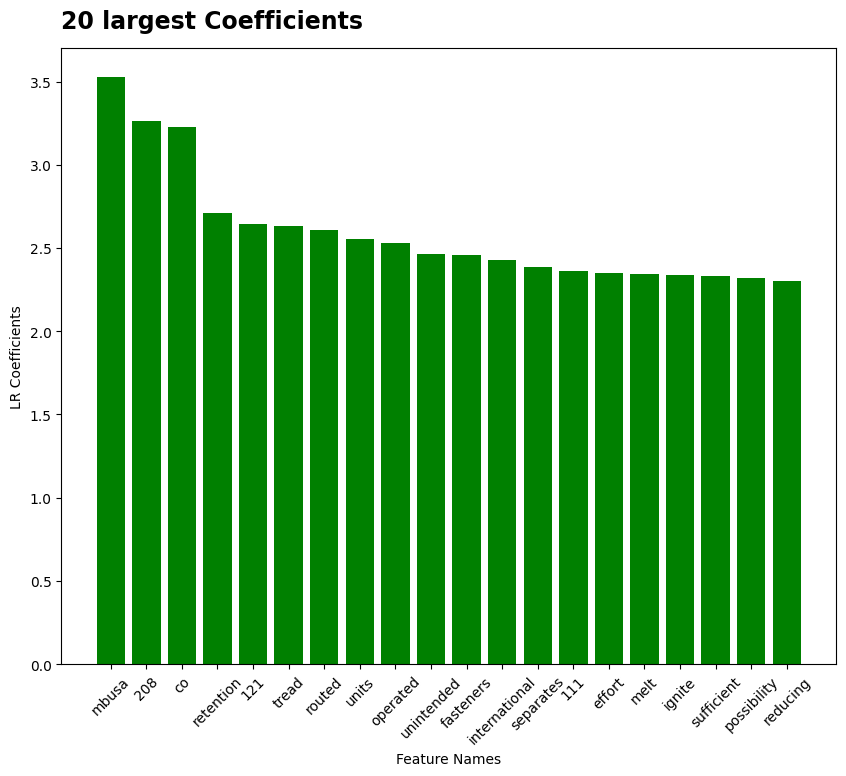

In [430]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=20
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


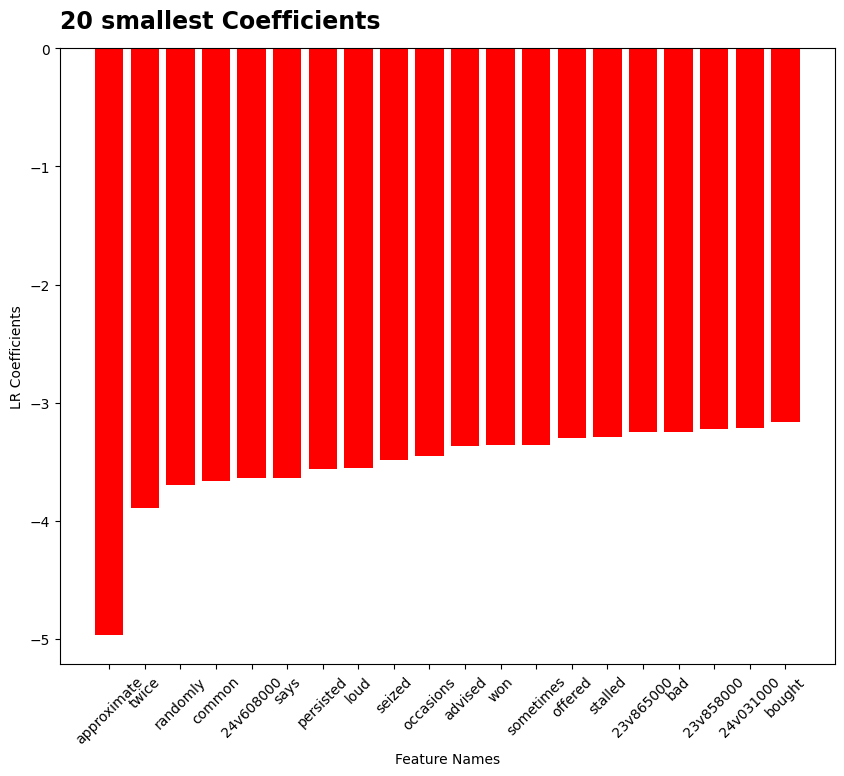

In [431]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=20
)

## What We Learned:
- Characters containing numbers can most likely be left out
- Recall contains a lot of junk information as expected. Might want to borrow columns other than CDESCR, which is a combination of DESC_DEFECT and CONSEQUENCE_EFFECT

# Experiments on CDESCR, COMPONENT

## Experiment 5:

In [536]:
recall_stopwords = ["crash", "risk", "increasing", "increase", "increases", "increased", "may", "could",
 "injury", "equipment", "loss", "resulting", "condition", "occur", "result", "event", "labels", "possibly"]

complaint_stopwords = ["unknown", "car", "driving", "issue", "dealer", "failed", "problem",
 "dealership", "issues", "times", "service", "back", "safety", "recall", "due", "like",
 ]

In [537]:
p = Preprocesser(
    "CDESCR_AND_COMPONENT",
    custom_clean_name="nltk_stopwords_cdescr_and_components",
    custom_vectorizer_name="tfidf_binary_unigram_bigram_cdescr_and_component",
    extra_stopwords=recall_stopwords + complaint_stopwords,
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,2),
        min_df=20,
        max_df=0.7,
        binary=True
    ),
    is_stem=True,
    rerun=False
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:84: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [538]:
c = Classifier(
    classifier=LogisticRegression,
    custom_classifier_name="lr_cdescr_and_components",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"],
    rerun=False
)

In [539]:
c.fit()

In [540]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.95      0.98      1150\n'
 '           1       0.98      1.00      0.99      2587\n'
 '\n'
 '    accuracy                           0.99      3737\n'
 '   macro avg       0.99      0.98      0.98      3737\n'
 'weighted avg       0.99      0.99      0.99      3737\n')


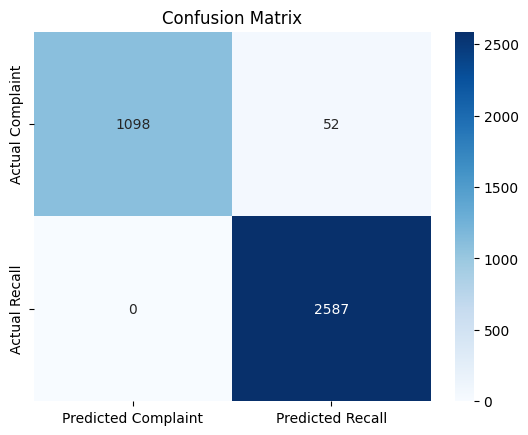

In [541]:
_ = c.plot_heatmap()

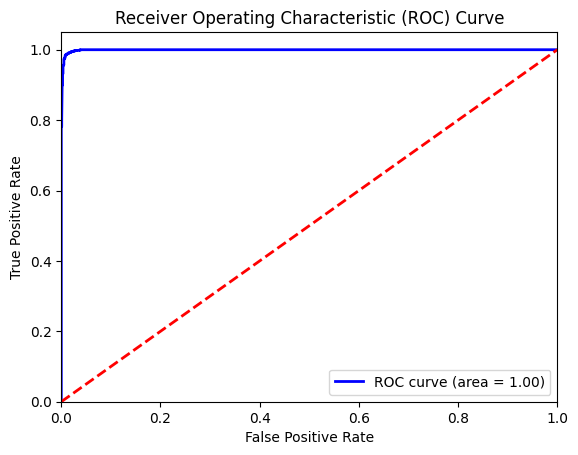

In [542]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  va="top", y=1.05)
C:\Users\harri\AppData\Local\Temp\ipykernel_25280\2193210731.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


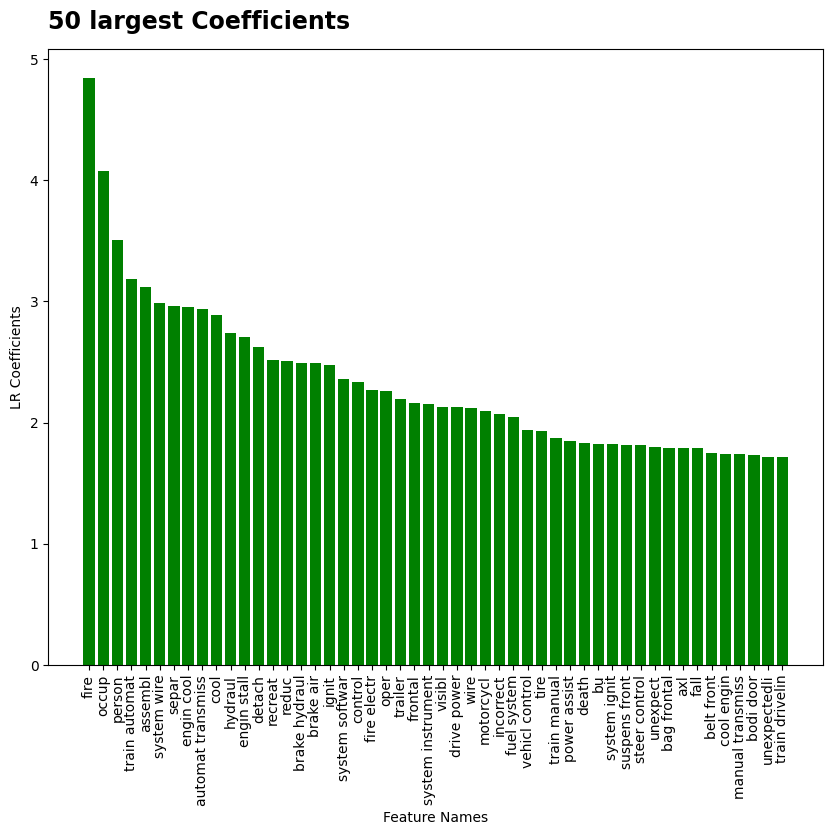

In [543]:
ax = c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=50
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  va="top", y=1.05)
C:\Users\harri\AppData\Local\Temp\ipykernel_25280\4030940537.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


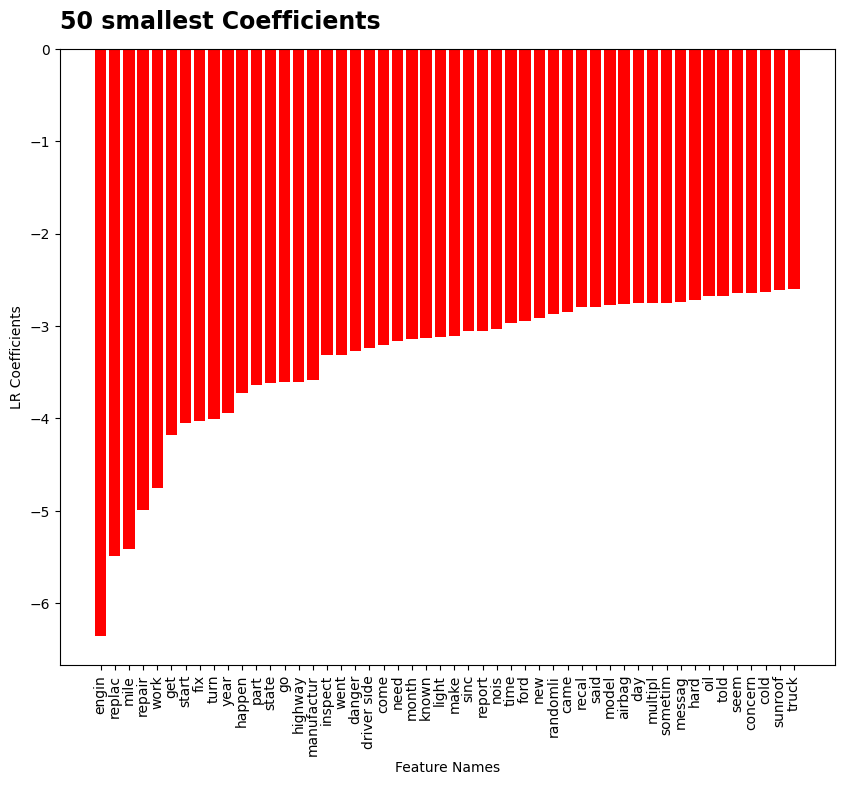

In [544]:
ax = c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=50
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [545]:
c = Classifier(
    classifier=LogisticRegression,
    custom_classifier_name="lr_cdescr_and_components",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_test_vect,
    y_test = p.df_test["IS_RECALL"],
    rerun=False
)

In [546]:
c.fit()

In [547]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.96      0.98      1168\n'
 '           1       0.98      1.00      0.99      2567\n'
 '\n'
 '    accuracy                           0.99      3735\n'
 '   macro avg       0.99      0.98      0.98      3735\n'
 'weighted avg       0.99      0.99      0.99      3735\n')


In [548]:
c.predict(
    "Electrical system failure",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.33289972, 0.66710028]])

In [549]:
c.predict(
    "Software going crazy boy",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.24671434, 0.75328566]])

In [586]:
c.predict(
    "speaker",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.07958145, 0.92041855]])

In [557]:
c.predict(
    "engine",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.97670928, 0.02329072]])

In [577]:
c.predict(
    "engine failure",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.88891848, 0.11108152]])

In [579]:
c.predict(
    "engine stall",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.04760448, 0.95239552]])

In [582]:
c.predict(
    "engine light",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.92159581, 0.07840419]])

In [584]:
c.predict(
    "air bag",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.19499939, 0.80500061]])

In [585]:
c.predict(
    "air bag sensor",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.2299502, 0.7700498]])

In [558]:
c.predict(
    "transmission",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.32953096, 0.67046904]])

In [559]:
c.predict(
    "harsh brake",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.14506071, 0.85493929]])

In [569]:
c.predict(
    "engine stalling",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.04760448, 0.95239552]])

In [592]:
c.predict(
    "engine clicking sound",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.83889682, 0.16110318]])

In [560]:
c.predict(
    "brake",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.26977233, 0.73022767]])

In [566]:
c.predict(
    "door open",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.16034278, 0.83965722]])

In [565]:
c.predict(
    "loose bolt",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.03703182, 0.96296818]])

In [561]:
c.predict(
    "light",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.62412789, 0.37587211]])

In [587]:
c.predict(
    "light sensor",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.69059987, 0.30940013]])

In [563]:
c.predict(
    "sensor is broken",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.30923887, 0.69076113]])

In [576]:
c.predict(
    "misfire",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.12602715, 0.87397285]])

In [575]:
c.predict(
    "speaker rattling",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.09877239, 0.90122761]])

In [574]:
c.predict(
    "steering wheel uneven",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.28013197, 0.71986803]])

In [590]:
c.predict(
    "steering wheel",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.40435474, 0.59564526]])

In [589]:
c.predict(
    "wheel jitter",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.05051488, 0.94948512]])

In [570]:
c.predict(
    "check engine light",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.93664851, 0.06335149]])

## Experiment 6:

Try SVD on TfIDF-Vector, then predict complaint and recall